In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.options.display.max_rows = 999
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices

from xgboost import XGBRegressor


In [2]:
FeatureTrain = pd.read_csv('./data/dengue_features_train.csv',parse_dates = ['week_start_date'])
TargetTrain = pd.read_csv('./data/dengue_labels_train.csv' )
FeatureTest = pd.read_csv('./data/dengue_features_test.csv',parse_dates = ['week_start_date'])
Answersheet = pd.read_csv('./data/submission_format.csv' )

### look at target first

In [3]:
"""
This is the difference between two measure

https://journals.ametsoc.org/doi/pdf/10.1175/BAMS-D-14-00226.1


"""

'\nThis is the difference between two measure\n\nhttps://journals.ametsoc.org/doi/pdf/10.1175/BAMS-D-14-00226.1\n\n\n'

In [4]:
panel = TargetTrain.merge(FeatureTrain,on = ['city','year','weekofyear'] ,how = 'outer') 
 
kelvin = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',   'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k','reanalysis_dew_point_temp_k']
panel.loc[:,kelvin] = panel.loc[:,kelvin]-273.15# kelvin to C
FeatureTest.loc[:,kelvin] =FeatureTest.loc[:,kelvin]-273.15# kelvin to C
panel.columns

timeid = ['year', 'weekofyear']
green = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']
precipitation  =['precipitation_amt_mm','reanalysis_sat_precip_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2',]
 
avg_temp = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',  'station_avg_temp_c' ]
   
min_temp = ['station_min_temp_c','reanalysis_min_air_temp_k']
 
max_temp = ['station_max_temp_c','reanalysis_max_air_temp_k']
 
dtr =  ['reanalysis_tdtr_k', 'station_diur_temp_rng_c']
 

humid = ['reanalysis_dew_point_temp_k','reanalysis_specific_humidity_g_per_kg', 'reanalysis_relative_humidity_percent']
 
selected = humid + dtr + max_temp +min_temp +avg_temp +precipitation +timeid+green + ['city','total_cases','week_start_date']
features_selected= humid + dtr + max_temp +min_temp +avg_temp +precipitation +timeid+green  
# precipitation_amt_mm  & reanalysis_sat_precip_amt_mm are the same
 
panel = panel.loc[:,selected]
 

In [5]:
sj = panel.loc[panel.city == 'sj'].interpolate()  .set_index('week_start_date').copy().drop(['city'],axis = 1)
iq = panel.loc[panel.city == 'iq']  .interpolate()  .set_index('week_start_date').copy().iloc[60:].drop(['city'],axis = 1)
 

In [6]:
city_name = 'iq'

iq_test = FeatureTest.loc[FeatureTest.city == city_name].interpolate().set_index('week_start_date').copy().drop('city',axis = 1)
iq_test['total_cases'] = np.nan 

iq = pd.concat([iq,iq_test ],sort = False)
 
train_len = len(iq_test['total_cases'])

 
data_selected = iq.loc[:,['total_cases']] .copy() 
data_candidate = iq .copy().iloc[: ]
data_candidate['green_n'] = data_candidate.loc[:,green[:2]].mean(1)
data_candidate['green_s'] = data_candidate.loc[:,green[2:]].mean(1)

In [7]:

def de_season_tri(data,target):
    data = data.copy()
    data["season_sin"] = np.sin(data.index.weekofyear/53*6.2831)
    data["season_cos"] = np.cos(data.index.weekofyear/53*6.2831)
    expr = """  ~ """
    expr = target + expr
    
    for name in ["season_sin","season_cos"]:
        expr +=     name  + ' + '
    expr = expr[:-2]
 
    Y , X  = dmatrices(expr, data, return_type='dataframe')
    if target == 'total_cases':
        Y = Y.clip(0,50)
    model = sm.OLS(Y,X)
    results = model.fit()
    
 
 
    
    return  data.loc[:,target] - results .predict(X)  ,results.params



def normalize(df, how ):
    if how == 'z':
        return (df - df.mean())/(df.std())
    if how == 'r':
        return (df - df.min())/(df.max() - df.min())

def seasonal_predict(data,params):
    data = data.copy()
    data["season_sin"] = np.sin(data.index.weekofyear/53*6.2831)
    data["season_cos"] = np.cos(data.index.weekofyear/53*6.2831)
    
    expr = """  ~ """
    expr = 'total_cases' + expr
    
    for name in ["season_sin","season_cos"]:
        expr +=     name  + ' + '
    expr = expr[:-2]
   
    Y , X  = dmatrices(expr, data, return_type='dataframe')
    
    return  X.dot(params)
# season _indicatores
residuals,params = de_season_tri(data_candidate,'total_cases')
data_selected['season_based'] = seasonal_predict(data_selected.fillna(0) ,params)

def append_shift(left,right,selected,shift,smooth =52):
    new_names = []
    for name in selected:
        new_name = name + '_shift_' +str(shift)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.rolling(smooth  ).mean().shift(shift).loc[:,name ]
    return left

def append_diff(left,right,selected,diff,smooth =52):
    new_names = []
    for name in selected:
        new_name = name + '_diff_' +str(diff)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.rolling(smooth  ).mean().diff(diff).loc[:,name ]
    return left

def append_non_season(left,right,selected,shift,smooth = 52):
    new_names = []
    for name in selected:
        new_name = name + '_de_season_' +str(shift)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        val,_ = de_season_tri(right,name)
        left[new_name]       = val.rolling(smooth   ).mean().shift(shift)
    return left

def append_product(left,right, selected,shift,smooth = 52):
    new_name = selected[0] + "_X_" + selected[1]
    left[new_name]       = right.loc[:,selected[0] ].multiply (right.loc[:,selected[1] ],axis = 0).rolling(smooth ).mean()
    return left
 
data_selected = append_shift(data_selected,data_candidate,\
      ['reanalysis_dew_point_temp_k', 'reanalysis_specific_humidity_g_per_kg',
         'station_min_temp_c' ],2,20)

data_selected = append_shift(data_selected,data_candidate,\
      ['precipitation_amt_mm'],2,100)


data_selected =  append_shift(data_selected,data_candidate,\
      [ 'station_min_temp_c',],2,52)

data_selected =  append_diff(data_selected,data_candidate,\
      [ 'reanalysis_relative_humidity_percent','station_min_temp_c'  ],52,20)

 
#data_selected =  append_product(data_selected,data_candidate ,\
#      [  'reanalysis_relative_humidity_percent','station_min_temp_c' ],2,20)
 

data_selected =  append_product(data_selected,data_candidate ,\
      [  'reanalysis_relative_humidity_percent','station_min_temp_c' ],0,20) 

data_selected =  append_product(data_selected,data_candidate ,\
      ['station_diur_temp_rng_c', 'reanalysis_relative_humidity_percent' ],0,20) 

 
 
['precipitation_amt_mm','reanalysis_sat_precip_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2',] 

['precipitation_amt_mm',
 'reanalysis_sat_precip_amt_mm',
 'station_precip_mm',
 'reanalysis_precip_amt_kg_per_m2']

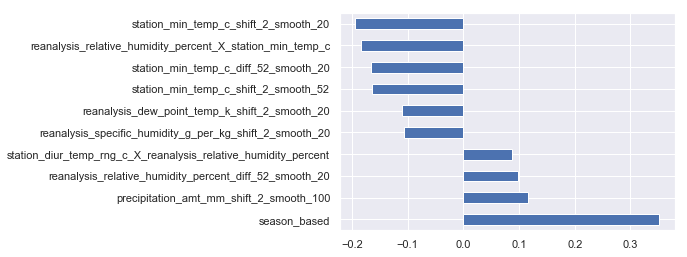

In [8]:
data_selected_corr = data_selected .corr().total_cases.drop([ 'total_cases'])
data_selected_corr  .sort_values(ascending=False) .plot.barh( )

In [9]:

data_temp = normalize( data_selected,'r')
data_temp['total_cases'] =  data_selected.total_cases

data_selected = data_temp.copy()



from sklearn.model_selection import KFold
data = data_selected.copy() .iloc[:-train_len ].dropna()
data_test = data_selected.copy().iloc[-train_len: ].fillna(method = 'ffill') .fillna(method = 'bfill').replace(np.nan,0)
kf = KFold(n_splits=4, random_state=None, shuffle=False)

expr = """total_cases ~   -1 + """
drops = ['total_cases','season_based' ]
for name in data.drop(drops,axis = 1).columns:
    expr +=    name + ' + '
expr=  expr[:-2]

maes = []
models = []
test_xs = []
test_ys = []

 






def normalize(df, how ):
    if how == 'z':
        return (df - df.mean())/(df.std())
    if how == 'r':
        return (df - df.min())/(df.max() - df.min())


for train_index, test_index in kf.split(data):
    
    df_train = data.iloc[train_index,:]
    df_test  = data.iloc[test_index,:]
    
    train_y,  train_X = dmatrices(expr, df_train, return_type='dataframe')
   
    test_y,  test_X = dmatrices(expr, df_test, return_type='dataframe')
    
    test_xs.append(test_X)
    
    test_ys.append(test_y)
    
    train_y = train_y.iloc[:,0] .clip(0,70) .dropna()
    train_X = train_X.loc[train_y.index]
    """model"""
    model = XGBRegressor(  base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.04, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=10, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1 )
    
    
    model .fit(X=train_X, y=pd.DataFrame(train_y))
    pred_res = pd.Series(model.predict(test_X)  ,index =  test_y .index)
 
    pred_res = pd.Series(pred_res,index =df_test.index )
    models.append(model)
    maes .append(abs(test_y.values.ravel()- pred_res.values.ravel()).mean())
    
 

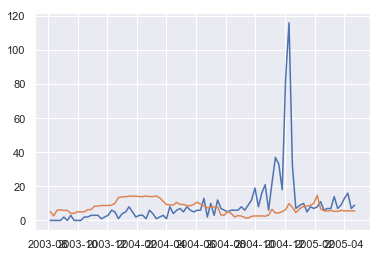

In [10]:
ith =0
plt.plot(  test_ys[ith] )
plt.plot(pd.Series(models[ith].predict(test_xs[ith] ),index = test_ys[ith].index)   )
 
 
 

In [11]:
maes

[8.47328316503101, 7.804980034298367, 9.076938135094112, 11.226937015404863]

In [12]:
np.mean(maes)

9.145534587457089

In [13]:
m1  = pd.Series(models[0].feature_importances_,index= train_X.columns).sort_values().iloc[-60:]
m2  = pd.Series(models[1].feature_importances_,index= train_X.columns).sort_values().iloc[-60:] 
m3  = pd.Series(models[2].feature_importances_,index= train_X.columns).sort_values().iloc[-60:]
m4  = pd.Series(models[3].feature_importances_,index= train_X.columns).sort_values().iloc[-60:]

In [14]:
(m3 ).sort_values() 

station_min_temp_c_shift_2_smooth_20                              0.042882
reanalysis_specific_humidity_g_per_kg_shift_2_smooth_20           0.073490
reanalysis_relative_humidity_percent_diff_52_smooth_20            0.082229
station_min_temp_c_shift_2_smooth_52                              0.094740
precipitation_amt_mm_shift_2_smooth_100                           0.107236
station_diur_temp_rng_c_X_reanalysis_relative_humidity_percent    0.108409
reanalysis_dew_point_temp_k_shift_2_smooth_20                     0.155245
station_min_temp_c_diff_52_smooth_20                              0.159448
reanalysis_relative_humidity_percent_X_station_min_temp_c         0.176322
dtype: float32

In [15]:
(m3 + m4).sort_values() 

reanalysis_specific_humidity_g_per_kg_shift_2_smooth_20           0.102784
station_min_temp_c_shift_2_smooth_20                              0.147870
reanalysis_relative_humidity_percent_diff_52_smooth_20            0.163455
station_min_temp_c_shift_2_smooth_52                              0.209731
precipitation_amt_mm_shift_2_smooth_100                           0.213729
station_diur_temp_rng_c_X_reanalysis_relative_humidity_percent    0.224485
reanalysis_dew_point_temp_k_shift_2_smooth_20                     0.229232
station_min_temp_c_diff_52_smooth_20                              0.287367
reanalysis_relative_humidity_percent_X_station_min_temp_c         0.421346
dtype: float32

'reanalysis_dew_point_temp_k'

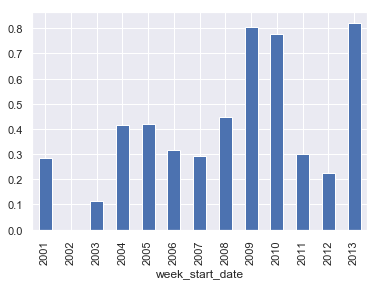

In [16]:
ith = 0
show = data_candidate .groupby(data_candidate.index.year).mean().iloc[:,ith]

show = (show - show .min()).plot.bar()
data_candidate.groupby(data_candidate.index.year).mean().iloc[:,ith].name

In [17]:
df_total  = data 
    
total_y,  total_X = dmatrices(expr, df_total, return_type='dataframe')
model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.04, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=10, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
model.fit( total_X ,total_y.iloc[:,[0]].clip(0,70))


pd.Series(np.round(model.predict(total_X )).astype(int),index = total_y.index).\
to_csv("./data/0126_xgb_train_" + str(city_name) + ".csv",header = False)

In [18]:
 
submit_y,  submit_X = dmatrices(expr, data_test , return_type='dataframe')

pd.Series(np.round(model.predict(submit_X)).astype(int),index = submit_y.index).\
to_csv("0126_xgb_" + str(city_name) + ".csv",header = False)

In [19]:
(abs(total_X.isnull()) > 1000).sum()

reanalysis_dew_point_temp_k_shift_2_smooth_20                     0
reanalysis_specific_humidity_g_per_kg_shift_2_smooth_20           0
station_min_temp_c_shift_2_smooth_20                              0
precipitation_amt_mm_shift_2_smooth_100                           0
station_min_temp_c_shift_2_smooth_52                              0
reanalysis_relative_humidity_percent_diff_52_smooth_20            0
station_min_temp_c_diff_52_smooth_20                              0
reanalysis_relative_humidity_percent_X_station_min_temp_c         0
station_diur_temp_rng_c_X_reanalysis_relative_humidity_percent    0
dtype: int64

In [20]:
 
from sklearn.model_selection import GridSearchCV
 
parameters = {'booster': ['gbtree'],'random_state':[1] , 'learning_rate':[0.04,0.06,0.1],\
              'n_estimators' :[100,200,300,400,500] , 'objective' : [  'reg:squarederror'] ,\
                               'reg_lambda' :[ 0.05,0.1,0,5,1,5,10]}
model =  XGBRegressor()
clf = GridSearchCV(model, parameters)
clf.fit(total_X , total_y.iloc[:,[0]])

sorted(clf.cv_results_.keys())
 

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_booster',
 'param_learning_rate',
 'param_n_estimators',
 'param_objective',
 'param_random_state',
 'param_reg_lambda',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [21]:
clf.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.04, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=10, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

### Based model